# Poiseuille - BGK - Zou-He Constant Velocity Inlet and Outlet

In [1]:
# Python Imports
from pylab import *
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors
from IPython.display import display, Math, Latex

## Setting Simulation

### Lattice Paremeters

In [2]:
w0=4.0/9.0;w1=1.0/9.0;w2=1.0/36.0; # Lattice Weights
w = np.array([w0,w1,w1,w1,w1,w2,w2,w2,w2],dtype="float64") 
cx = np.array([0,1,0,-1, 0,1,-1,-1, 1],dtype="int8")  # Lattice Directions
cy = np.array([0,0,1, 0,-1,1, 1,-1,-1],dtype="int8")  # Lattice Directions
opp = np.array([0,3,4,1,2,7,8,5,6],dtype="uint8")  # Opposite Lattice Directions

### Problem Scaling: From Dimensionless to LBM Scale

In [3]:
#------------Dimensionless Parameter For Pro----------------
uo = 1.0 # Dimensionless Velocity
ho = 1.0 # Dimensionless Domain Length
Re = 10.0 # Reynolds Number
nuo = uo*ho/Re #Dimensionless Kinematic Viscosity

The problem scaling follow the equations:
$$
\Delta x=\frac{H_{0}}{Nx}, \quad \quad r=\frac{\Delta x}{\Delta t}, \quad \quad u=u_{0}\frac{\Delta t}{\Delta x}, \quad \quad \textrm{and} \quad \quad \nu=\nu_{0}\frac{\Delta t}{\Delta x^{2}}
$$
where $\Delta x $ is grid size, $\Delta y$ is time step and $r$ is the relation term. Dimensionless numbers
$$
Re=\frac{u_{0}\rho H}{\mu}=\frac{u_{0} H}{\nu} \quad \quad \textrm{and} \quad \quad C_{d}=\frac{24}{Re}\frac{L}{H}.
$$

In [4]:
import time
#---------------Numerical Domain Size--------------------
cases=3
Nx0 = np.array([10, 20, 40],dtype="int64")
Ny0 = np.array([12, 22, 42],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
mstep=10000
mstep0 = np.array([mstep*4**(0), mstep*4**(1), mstep*4**(2)],dtype="int64")
rhor = np.empty(len(Nx0), dtype=object)
Vxr = np.empty(len(Nx0), dtype=object)
Vyr = np.empty(len(Nx0), dtype=object)
Cdr = np.zeros((3),dtype="float64")
Mass = np.empty(len(Nx0), dtype=object)
for i in range(len(Nx0)):
    rhor[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Vxr[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Vyr[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Mass[i] = np.zeros((int(mstep0[i])), dtype="float64")
for case in range(0,cases):
    Nx=Nx0[case]
    Ny=Ny0[case]
    #------------------------------------------Scaling Term--------------------------------------------
    dx = ho / (Ny-2) # Grid size 
    r = r0[case] # Relation term r=dx/dt
    dt = dx / r # Time Step
    #----------------------------------------LBM-Scale-----------------------------------------------
    nu = dt * nuo / (dx * dx)  #Scaling Viscosity
    ue = dt * uo / dx  #Scaling Velocity
    cs = 1.0 / sqrt(3.) #Sound Speed
    tau = (nu/ (cs * cs)) + (1.0/ 2.0) #Relaxation time
    rhoi = 1.0 #Initial Densty
    #--------------Print-Data-------------------------------------------------------------------------
    display(Math(r"\tau="+str(tau)+r"\quad\quad \nu="+str(nu)))
    display(Math(r"r="+str(r)+r"\quad\quad \overline{u}="+str(ue)))
    display(Math(r"dx="+str(dx)+r"\quad\quad dt="+str(dt)))
    #----------------Allocating array of solid nodes------------------------------------------------
    solid=np.ones((Nx,Ny),dtype="uint8") # Binary array to allocate the mapp of pore and solid # Parallel Plates
    solid[:,0] = 0
    solid[:,Ny-1] = 0
    #--------Allocating "imapp" array ti store the information of lattice directions that need be 
    # inverted during the Half-way Bounce-Back method.
    imapp=np.zeros((9,Nx,Ny),dtype="uint8") #Interface mapping for Half-Way Bounce-Back
    for i in range(0,Nx):
        for j in range (0, Ny):
            if (solid[i,j]==1):
                for k in range (0,9):
                    #-----------------------------------------
                    ii=i+cx[k] 
                    if (ii>Nx-1):ii=0
                    if (ii<0):ii=Nx-1
                    #-----------------------------------------
                    jj=j+cy[k] 
                    if (jj>Ny-1):jj=0
                    if (jj<0):jj=Ny-1
                    #-----------------------------------------
                    if (solid[ii,jj]==0):
                        imapp[k,i,j]=k
    #---------------------Field-Arrays---------------------------------------------------------------- 
    rho=np.zeros((Nx,Ny),dtype="float64") # Allocating Density field
    rho[:,:]=np.where(solid==1,rhoi,0.0) # Constant initial density field
    rhow=np.zeros((Ny),dtype="float64") # Allocating West Boundary Density
    rhoe=np.zeros((Ny),dtype="float64") # Allocating East Boundary Density
    up=np.zeros((Ny),dtype="float64") # Allocating Boundary Parabolic Profile
    y=np.linspace(0.5, Ny-2 -0.5, Ny-2)
    up[1:-1]=6.0 * ue * ( y/float(Ny - 2) - ( y/float(Ny - 2) )**2 );
    Vx=np.zeros((Nx,Ny),dtype="float64") # Allocating Null Velocity x Field
    Vy=np.zeros((Nx,Ny),dtype="float64") # Allocating Null Velocity y Field
    #----------------Initializing Distribution Functions----------------
    f=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pre-Collisional Distribution Function
    fp=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pos-Collisional Distribution Function
    feq=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pos-Collisional Distribution Function
    for k in range (0,9):
        f[k,:,:]=np.where(solid==1,w[k]*rho[:,:],0.0)
    #---------------------------------Main-Loop-------------------------------------------------------
    Cd=0.0; Cd0=0.0
    tolerance=0.000001
    start=time.time()
    #---------------------------------Main-Loop-------------------------------------------------------------------------------------
    for kk in range(0,mstep0[case]):
        #------------------------------------Collision-----------------------------------------------------------------------------
        for k in range(0,9):
            feq[k,:,:]=w[k]*rho*(1. + 3.*(Vx*cx[k]+Vy*cy[k]) + 4.5*(Vx*cx[k]+Vy*cy[k])**2-1.5*(Vx*Vx+Vy*Vy))
            fp[k,:,:]=np.where(solid==1, f[k,:,:]-(1.0/tau)*(f[k,:,:]-feq[k,:,:]), 0.0 )
        #----------------------------------Streaming---------------------------------------------------------------------------
        for k in range(0,9):
            f[k,:,:]=np.roll(np.roll(fp[k,:,:], cx[k], axis=0), cy[k], axis=1)
        #--------------------------------------Half-Way-------------------------------------------------------------------------
        for k in range(1,9):
            f[k,:,:]=np.where(imapp[opp[k],:,:]==opp[k],fp[opp[k],:,:],f[k,:,:])
        #--------------------------------------Zou-He-BC------------------------------------------------------------------------
        #--------------------Inlet------------------------------------------------------------
        rhow= (f[0,0,:] + f[2,0,:] + f[4,0,:] + 2 * (f[3,0,:] + f[6,0,:] +f[7,0,:]) )/(1.0-up)
        f[1,0,:] = f[3,0,:] + 2.0*rhow*up/3.0
        f[5,0,:] = f[7,0,:] - (f[2,0,:]-f[4,0,:])/2.0 + rhow*up/6.0
        f[8,0,:] = f[6,0,:] + (f[2,0,:]-f[4,0,:])/2.0 + rhow*up/6.0
        #--------------------Outlet (Breuer)------------------------------------------------------------
        rhow = 2.0*rho[Nx-2, :] - rho[Nx-3, :]

        t1 = up**2
        t2 = np.zeros((3, Ny))

        # Direções k = 3, 6, 7
        for idx, k in enumerate([3, 6, 7]):
            t2[idx, :] = up * cx[k]
            f[k, Nx-1, :] = (
                rhow * w[k] *
                (1.0 + 3.0 * t2[idx, :] + 4.5 * t2[idx, :]**2 - 1.5 * t1)
            ) 
        #--------------------------------------Macro-Properties------------------------------------------------------------------
        rho=np.where(solid==1,np.einsum('ixy->xy', f),0.0) 
        Vx=np.divide(np.einsum('i,ixy->xy', cx, f), rho, out=np.zeros_like(Vx, dtype="float64"), where=rho!=0)
        Vy=np.divide(np.einsum('i,ixy->xy', cy, f), rho, out=np.zeros_like(Vy, dtype="float64"), where=rho!=0)
        #-------------------------------------Convergence------------------------------------------------------------------------
        rho_med = np.sum(rho)/(Nx*(Ny-2))
        Mass[case][kk] = rho_med
        if (kk%1000==0):
            Umed = np.sum(Vx)/(Nx*(Ny-2))
            rho_med = np.sum(rho)/(Nx*(Ny-2))
            dp = (sum(rho[0,:]) - sum(rho[Nx-1,:]))*cs**2/(Ny-2)
            Cd=dp/(rho_med*Umed**2/2.0)
            print('Da=',Cd,'\t Diff=',np.fabs(Cd-Cd0),'\t Umed=',Umed,'\t Erro=',np.fabs(Cd-24.0/Re))
            # if(np.fabs(Cd-Cd0)<tolerance):
            #     break
            Cd0=Cd
    Cdr[case]=Cd
    rhor[case]=rho
    Vxr[case]=Vx
    Vyr[case]=Vy

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 398.96277808440595 	 Diff= 398.96277808440595 	 Umed= 0.018260331021174813 	 Erro= 396.562778084406
Da= 2.0928566296871596 	 Diff= 396.8699214547188 	 Umed= 0.1262856322384006 	 Erro= 0.30714337031284034
Da= 2.092856629685203 	 Diff= 1.956657058599376e-12 	 Umed= 0.12628563223837225 	 Erro= 0.307143370314797
Da= 2.0928566296851976 	 Diff= 5.329070518200751e-15 	 Umed= 0.12628563223837228 	 Erro= 0.3071433703148023
Da= 2.0928566296852043 	 Diff= 6.661338147750939e-15 	 Umed= 0.12628563223837222 	 Erro= 0.30714337031479566
Da= 2.0928566296851843 	 Diff= 1.9984014443252818e-14 	 Umed= 0.12628563223837222 	 Erro= 0.30714337031481564
Da= 2.092856629685206 	 Diff= 2.1760371282653068e-14 	 Umed= 0.12628563223837222 	 Erro= 0.3071433703147939
Da= 2.092856629685193 	 Diff= 1.2878587085651816e-14 	 Umed= 0.12628563223837225 	 Erro= 0.30714337031480676
Da= 2.0928566296851896 	 Diff= 3.552713678800501e-15 	 Umed= 0.12628563223837222 	 Erro= 0.3071433703148103
Da= 2.0928566296852162 	 Diff= 2.6

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 3002.116929693679 	 Diff= 3002.116929693679 	 Umed= 0.0046276267992241375 	 Erro= 2999.716929693679
Da= 2.1729294651840303 	 Diff= 2999.944000228495 	 Umed= 0.06264956345469763 	 Erro= 0.22707053481596962
Da= 2.1911219905799744 	 Diff= 0.01819252539594407 	 Umed= 0.06264177180404211 	 Erro= 0.20887800942002555
Da= 2.1911155073186417 	 Diff= 6.483261332679291e-06 	 Umed= 0.06264176539228815 	 Erro= 0.20888449268135822
Da= 2.1911155061803624 	 Diff= 1.138279248635854e-09 	 Umed= 0.06264176539617586 	 Erro= 0.20888449381963747
Da= 2.191115506181984 	 Diff= 1.6213697051625786e-12 	 Umed= 0.0626417653961757 	 Erro= 0.2088844938180161
Da= 2.1911155061821206 	 Diff= 1.3677947663381929e-13 	 Umed= 0.06264176539617566 	 Erro= 0.20888449381787932
Da= 2.1911155061820997 	 Diff= 2.0872192862952943e-14 	 Umed= 0.06264176539617573 	 Erro= 0.2088844938179002
Da= 2.1911155061820806 	 Diff= 1.9095836023552692e-14 	 Umed= 0.0626417653961757 	 Erro= 0.2088844938179193
Da= 2.1911155061820544 	 Diff= 2

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 23355.022804914865 	 Diff= 23355.022804914865 	 Umed= 0.0011644728460391814 	 Erro= 23352.622804914863
Da= 1.9145320863795123 	 Diff= 23353.108272828485 	 Umed= 0.028789209954373084 	 Erro= 0.4854679136204876
Da= 2.2053265913750426 	 Diff= 0.2907945049955303 	 Umed= 0.031018346825540187 	 Erro= 0.1946734086249573
Da= 2.248049452221016 	 Diff= 0.04272286084597354 	 Umed= 0.03124031951095824 	 Erro= 0.15195054777898376
Da= 2.254505024596354 	 Diff= 0.00645557237533767 	 Umed= 0.031262465703424655 	 Erro= 0.1454949754036461
Da= 2.2553822123899816 	 Diff= 0.0008771877936277761 	 Umed= 0.031264674139081246 	 Erro= 0.1446177876100183
Da= 2.255493169069811 	 Diff= 0.00011095667982941038 	 Umed= 0.0312648942011294 	 Erro= 0.1445068309301889
Da= 2.2555065785047015 	 Diff= 1.3409434890476746e-05 	 Umed= 0.03126491611221344 	 Erro= 0.14449342149529842
Da= 2.255508149460178 	 Diff= 1.5709554763709832e-06 	 Umed= 0.03126491829211475 	 Erro= 0.14449185053982205
Da= 2.255508329400474 	 Diff= 1.79

Da= 2.2555083521900827 	 Diff= 1.9317880628477724e-13 	 Umed= 0.03126491853271153 	 Erro= 0.1444916478099172
Da= 2.2555083521898847 	 Diff= 1.9806378759312793e-13 	 Umed= 0.03126491853271152 	 Erro= 0.14449164781011525
Da= 2.255508352190061 	 Diff= 1.7630341631047486e-13 	 Umed= 0.03126491853271152 	 Erro= 0.14449164780993895
Da= 2.2555083521899957 	 Diff= 6.52811138479592e-14 	 Umed= 0.03126491853271155 	 Erro= 0.14449164781000423
Da= 2.2555083521901653 	 Diff= 1.6964207816272392e-13 	 Umed= 0.031264918532711516 	 Erro= 0.1444916478098346
Da= 2.2555083521899006 	 Diff= 2.646771690706373e-13 	 Umed= 0.031264918532711544 	 Erro= 0.14449164781009927
Da= 2.255508352190085 	 Diff= 1.8429702208777599e-13 	 Umed= 0.03126491853271153 	 Erro= 0.14449164780991497
Da= 2.255508352189921 	 Diff= 1.638689184346731e-13 	 Umed= 0.03126491853271156 	 Erro= 0.14449164781007884
Da= 2.255508352189815 	 Diff= 1.0613732115416497e-13 	 Umed= 0.031264918532711544 	 Erro= 0.14449164781018498
Da= 2.25550835218

Da= 2.255508352190021 	 Diff= 5.950795411990839e-14 	 Umed= 0.03126491853271154 	 Erro= 0.14449164780997892
Da= 2.2555083521899806 	 Diff= 4.04121180963557e-14 	 Umed= 0.031264918532711516 	 Erro= 0.14449164781001933
Da= 2.255508352190005 	 Diff= 2.4424906541753444e-14 	 Umed= 0.03126491853271157 	 Erro= 0.1444916478099949
Da= 2.25550835219004 	 Diff= 3.5083047578154947e-14 	 Umed= 0.03126491853271151 	 Erro= 0.14449164780995982
Da= 2.255508352190166 	 Diff= 1.2612133559741778e-13 	 Umed= 0.03126491853271151 	 Erro= 0.1444916478098337
Da= 2.255508352189806 	 Diff= 3.601563491884008e-13 	 Umed= 0.03126491853271151 	 Erro= 0.14449164781019386
Da= 2.2555083521900823 	 Diff= 2.7622348852673895e-13 	 Umed= 0.0312649185327115 	 Erro= 0.14449164780991763
Da= 2.2555083521900836 	 Diff= 1.3322676295501878e-15 	 Umed= 0.0312649185327115 	 Erro= 0.1444916478099163


Text(0, 0.5, '$Y$')

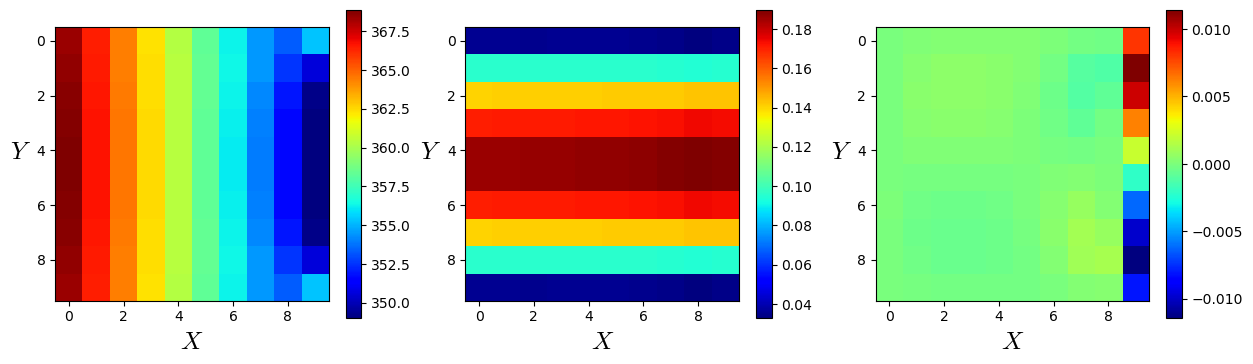

In [7]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
fig1, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(15,4))
img1=ax1.imshow(np.rot90(rhor[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img1, ax=ax1)
ax1.set_xlabel('$X$',fontsize=18)
ax1.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0)
img2=ax2.imshow(np.rot90(Vxr[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img2, ax=ax2)
ax2.set_xlabel('$X$',fontsize=18)
ax2.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 
img3=ax3.imshow(np.rot90(Vyr[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img3, ax=ax3)
ax3.set_xlabel('$X$',fontsize=18)
ax3.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 

In [8]:
Nx0 = np.array([10, 20, 40],dtype="int64")
Ny0 = np.array([12, 22, 42],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
Vxana = np.empty(len(Nx0), dtype=object)
for i in range(len(Nx0)):
    Vxana[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
for i in range(len(Nx0)):
    y=np.linspace(0.5, Ny0[i]-2 -0.5, Ny0[i]-2) / float(Ny0[i] - 2)
    for ix in range(Nx0[i]):
        Vxana[i][ix,1:-1]=6.0 * (1.0/r0[i]) * ( y - ( y )**2 );

Text(0, 0.5, '$Y$')

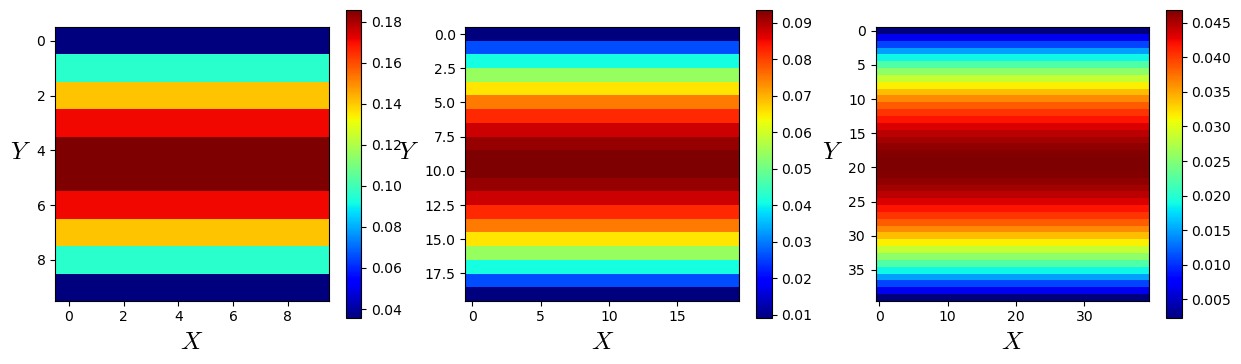

In [10]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
fig1, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(15,4))
img1=ax1.imshow(np.rot90(Vxana[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img1, ax=ax1)
ax1.set_xlabel('$X$',fontsize=18)
ax1.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0)
img2=ax2.imshow(np.rot90(Vxana[1][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img2, ax=ax2)
ax2.set_xlabel('$X$',fontsize=18)
ax2.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 
img3=ax3.imshow(np.rot90(Vxana[2][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img3, ax=ax3)
ax3.set_xlabel('$X$',fontsize=18)
ax3.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 

In [11]:
E0=sqrt(sum((Vxr[0][:,:]-Vxana[0][:,:])**2))/sqrt(sum((Vxana[0][:,:])**2))
E1=sqrt(sum((Vxr[1][:,:]-Vxana[1][:,:])**2))/sqrt(sum((Vxana[1][:,:])**2))
E2=sqrt(sum((Vxr[2][:,:]-Vxana[2][:,:])**2))/sqrt(sum((Vxana[2][:,:])**2))

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_46433/2903882536.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta x$',fontsize=16)


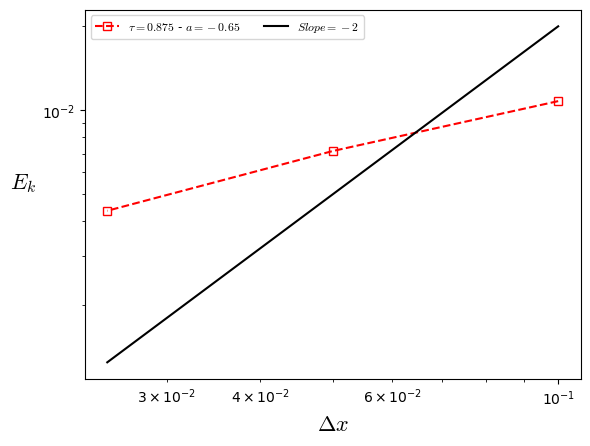

In [12]:
Malha=np.array([10,20,40])
Ek = np.array([E0,E1,E2])
TEk=np.polyfit(np.log(Malha), np.log(Ek), 1)
# Ek1 = np.array([0.000885053175400552,0.0002657329674660147,7.199195200913167e-05,1.8693115438450647e-05])
# TEk1=np.polyfit(np.log(Malha), np.log(Ek1), 1)
plt.loglog(1/Malha,Ek,'rs--',fillstyle='none')
# plt.loglog(1/Malha,Ek1,'bs--',fillstyle='none')
plt.loglog(1/Malha,2.0*1.0/(Malha**2),'k-',fillstyle='none')
plt.ylabel('$E_{k}$',fontsize=16,rotation=0,horizontalalignment='right')
plt.xlabel('$\Delta x$',fontsize=16)
plt.legend([fr'$\tau=0.875$ - $a={TEk[0]:.2f}$','$Slope=-2$'],loc=2,ncol=3,fontsize=8.5)

<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_46433/3887496154.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\overline{M}$',fontsize=16,rotation=0,horizontalalignment='right')


Text(0.5, 0, '$t$')

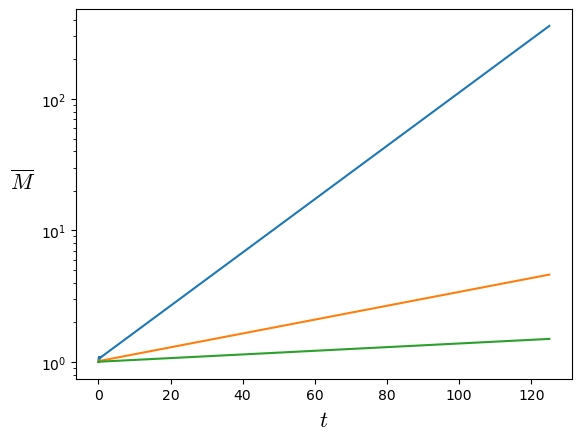

In [14]:
Nx0 = np.array([10, 20, 40],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
plt.semilogy(np.linspace(0,len(Mass[0]),len(Mass[0]))/Nx0[0]/r0[0],Mass[0])
plt.plot(np.linspace(0,len(Mass[1]),len(Mass[1]))/Nx0[1]/r0[1],Mass[1])
plt.plot(np.linspace(0,len(Mass[2]),len(Mass[2]))/Nx0[2]/r0[2],Mass[2])
plt.ylabel('$\overline{M}$',fontsize=16,rotation=0,horizontalalignment='right')
plt.xlabel('$t$',fontsize=16)